In [1]:
import pints
import pints.toy as toy
import pints.plot

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
import emupints.metrics as emumet

from emupints.models import create_small_model, create_average_model, create_large_model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

import string

# Problem parameters

In [2]:
# Load problem from predefined ones
model = emupints.Problems.HodgkinHuxleyIKModel
problem = emupints.Problems.load_problem(model)

problem['values'][:5]

array([191.87051425, 176.15234849, -36.70440822, 101.2258256 ,
       408.28191302])

In [3]:
# take all the required variables from the problem
n_parameters = problem['n_parameters']
log_likelihood = problem['log_likelihood']
log_prior = problem['log_prior']
log_posterior = problem['log_posterior']
real_parameters = problem['parameters']
pints_problem = problem['problem']
bounds = problem['bounds']
index_to_param_name = problem['param_names']

# Apply CMA-ES

In [4]:
# CMA-es
score = pints.SumOfSquaresError(pints_problem)
x0 = bounds.sample(1)[0]

found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      1.52e+09   0:00.1
1     16     1.87e+08   0:00.2
2     24     1.87e+08   0:00.3
3     32     1.87e+08   0:00.3
20    168    1.83e+08   0:06.0
40    328    1.83e+08   0:13.1
60    488    1.83e+08   0:23.0
80    648    1.83e+08   0:34.1
100   808    1.83e+08   0:43.6
120   968    1.83e+08   0:53.0
140   1128   1.83e+08   1:02.6
160   1288   1.83e+08   1:15.2
180   1448   1.83e+08   1:34.3
200   1608   1.83e+08   1:47.2
220   1768   1.83e+08   1:59.5
240   1928   1.83e+08   2:10.5
260   2088   1.83e+08   2:29.4
280   2248   1.83e+08   2:42.5
300   2408   1.83e+08   2:56.4
320   2568   1.83e+08   3:09.7
340   2728   1.83e+08   3:21.5
360   2888   1.83e+08   3:34.5
380   3048   1.83e+08   3:46.3
400   3208   1.83e+08   3:58.5
420   3368   1.83e+08   4:09.9
440   3528   1.83e+08   4:21.3
460   3688   1.83e+08   4:32

# Use found parameters to sample trianing data

In [5]:
# training size
# use bigger training size for NNs because speed stays the same
train_size = 5000
test_size = 400
sampling_std = 0.05 * found_parameters # take 0.05% around found parameters std

def normal_sampling(size, mean, std):
    return mean + np.random.randn(*size) * std

# create data for training and testing
# genera example using normal distribution around parametrs
train_X = normal_sampling((train_size, n_parameters), found_parameters, sampling_std)
train_y = np.apply_along_axis(log_likelihood, 1, train_X)

# if provide validation data to keras model also need to normalize it 
test_X = normal_sampling((test_size, n_parameters), found_parameters, sampling_std)
test_y = np.apply_along_axis(log_likelihood, 1, test_X)

# Create NN emulator

In [6]:
EPOCHS = 50
BATCH = 32
validation_split = 0.2

In [7]:
# how to scale data
# for input use standardisation, same as GPs
# for output scale linearly in range (-1, 1)
input_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler = StandardScaler()

In [8]:
emu = emupints.NNEmulator(log_likelihood, 
                          train_X,
                          train_y,
                          model_size='large',
                          input_scaler=input_scaler, 
                          output_scaler=output_scaler
                         )

In [9]:
# print summary of the model
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 82,945
Trainable params: 82,945
Non-trainable params: 0
_________________________________________________________________


In [10]:
# store best
mc_callback = keras.callbacks.ModelCheckpoint("models/model_{epoch:02d}.h5", 
                                              save_weights_only=True,  
                                             )

In [11]:
# store the results during training
val_umae = []

# Callback to calculate unormalized mae
class UnormalizedMAE(keras.callbacks.Callback):

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        
        y_val_predict = np.asarray(self.model.predict(X_val))

        # unormalize predictions
        y_val = output_scaler.inverse_transform(y_val)
        y_val_predict = output_scaler.inverse_transform(y_val_predict)

        # calculate mae
        mae_val = np.mean(np.abs(y_val - y_val_predict))

        # store results
        val_umae.append(mae_val)

        return

In [12]:
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
emu.set_parameters(
    loss='mse',
    optimizer='adam',
    metrics=['mae'] # mean absolute error
)

In [13]:
history = emu.fit(epochs=EPOCHS,
                  batch_size=BATCH,
                  validation_split=0.2,
                  callbacks=[mc_callback,UnormalizedMAE()],
                 )

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 178us/step - loss: 2.6111 - mean_absolute_error: 0.6132 - val_loss: 1.0738 - val_mean_absolute_error: 0.4841
Epoch 2/50
4000/4000 [==============================] - 0s 68us/step - loss: 0.7992 - mean_absolute_error: 0.4711 - val_loss: 0.5976 - val_mean_absolute_error: 0.4021
Epoch 3/50
4000/4000 [==============================] - 0s 66us/step - loss: 0.5637 - mean_absolute_error: 0.3870 - val_loss: 0.4950 - val_mean_absolute_error: 0.3511
Epoch 4/50
4000/4000 [==============================] - 0s 65us/step - loss: 0.4797 - mean_absolute_error: 0.3405 - val_loss: 0.4574 - val_mean_absolute_error: 0.3269
Epoch 5/50
4000/4000 [==============================] - 0s 68us/step - loss: 0.4375 - mean_absolute_error: 0.3163 - val_loss: 0.4597 - val_mean_absolute_error: 0.3225
Epoch 6/50
4000/4000 [==============================] - 0s 63us/step - loss: 0.4252 - mean_absolute_error: 0.3135 - 

4000/4000 [==============================] - 0s 63us/step - loss: 0.3137 - mean_absolute_error: 0.2430 - val_loss: 0.3198 - val_mean_absolute_error: 0.2403
Epoch 50/50
4000/4000 [==============================] - 0s 64us/step - loss: 0.3137 - mean_absolute_error: 0.2407 - val_loss: 0.3142 - val_mean_absolute_error: 0.2398


In [14]:
best_model_idx = np.argmin(val_umae)
emu._model.load_weights("models/model_{:02d}.h5".format(best_model_idx))

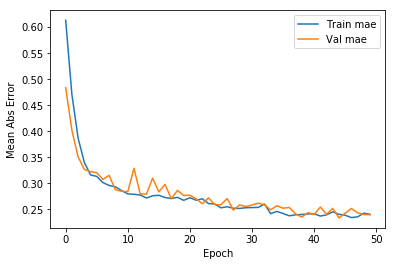

In [15]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
       label='Train mae')
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
       label = 'Val mae')
plt.legend()

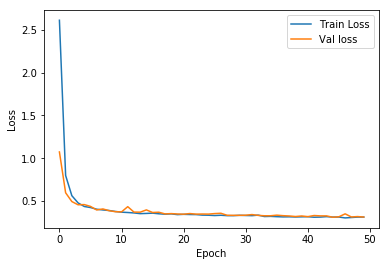

In [16]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, np.array(history.history['loss']),
       label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']),
       label = 'Val loss')
plt.legend()

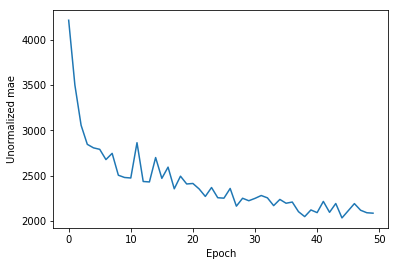

In [17]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Unormalized mae')
plt.plot(history.epoch, val_umae)

# Likelihood metrics

In [18]:
emu_time = %timeit -r 50 -o emu(real_parameters)
print("Emulator prediction time (micro-seconds): {:5f}".format(emu_time.average * 1000000))

474 µs ± 16.8 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)
Emulator prediction time (micro-seconds): 473.528428


In [19]:
likelihood_time = %timeit -r 50 -o log_likelihood(real_parameters)
print("Likelihood prediction time (micro-seconds): {:5f}".format(likelihood_time.average * 1000000))

71.9 ms ± 688 µs per loop (mean ± std. dev. of 50 runs, 10 loops each)
Likelihood prediction time (micro-seconds): 71858.520494


In [20]:
pred_y = np.apply_along_axis(emu, 1, test_X)
print("Mean absolute error (mae): {:.5f}".format(emumet.mae(test_y, pred_y)))

Mean absolute error (mae): 8019.77914


In [21]:
print("Mean percentage error (mape): {:.5f}".format(emumet.mape(test_y, pred_y) * 100))

Mean percentage error (mape): 20.22106


# Comparing MCMC run times

In [22]:
mcmc_method = pints.AdaptiveCovarianceMCMC

# MCMC parameters
num_chains = 3
max_iters = 10000

In [23]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_log_posterior = pints.LogPosterior(emu, log_prior)

In [28]:
print(found_parameters)

[9.77886033e-03 9.00000138e+00 1.01684608e+01 1.31197209e-01
 7.20000002e+01]


In [29]:
xs = [
    found_parameters,
    found_parameters,
    found_parameters
]
xs

[array([9.77886033e-03, 9.00000138e+00, 1.01684608e+01, 1.31197209e-01,
        7.20000002e+01]),
 array([9.77886033e-03, 9.00000138e+00, 1.01684608e+01, 1.31197209e-01,
        7.20000002e+01]),
 array([9.77886033e-03, 9.00000138e+00, 1.01684608e+01, 1.31197209e-01,
        7.20000002e+01])]

In [30]:
emu_mcmc = pints.MCMCSampling(emu_log_posterior,
                              num_chains,
                              xs,
                              method = mcmc_method,
                             )
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!


In [31]:
real_mcmc = pints.MCMCSampling(log_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                               )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...
Done!


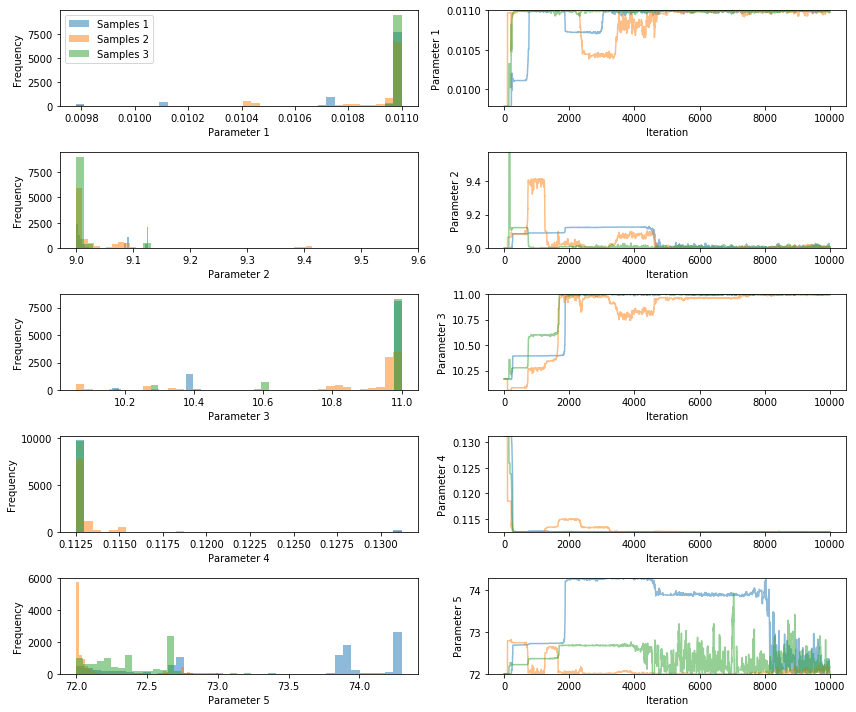

In [32]:
pints.plot.trace(emu_chains)
plt.show()

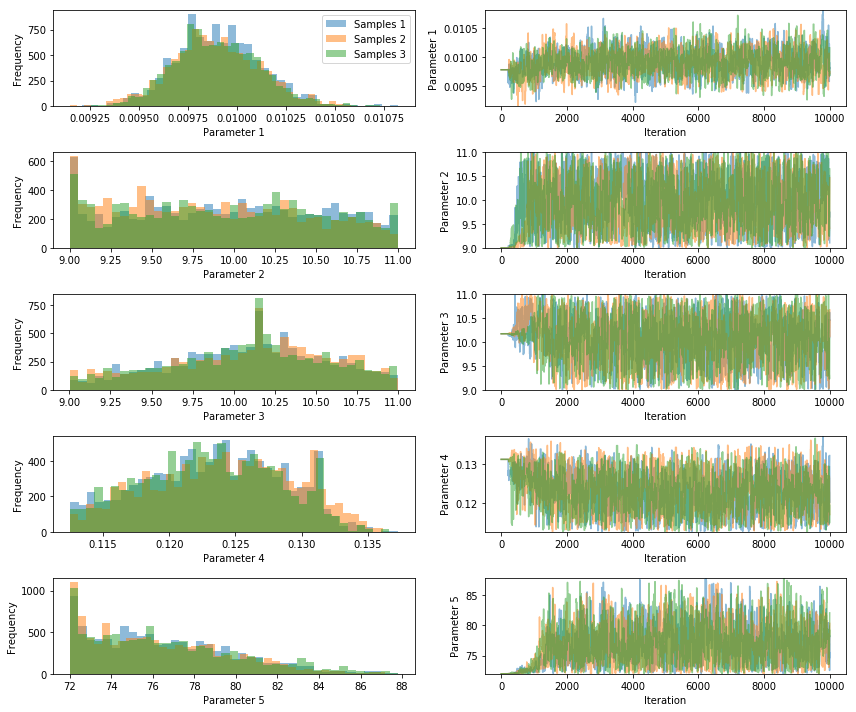

In [33]:
pints.plot.trace(real_chains)
plt.show()

# MCMC metrics

In [34]:
print('Emulator R-hat:')
print(pints.rhat_all_params(emu_chains))

Emulator R-hat:
[1.0203976959863101, 1.0452352252925956, 1.0117648037855094, 1.0005288210120822, 1.7284138789641024]


In [35]:
print('Real R-hat:')
print(pints.rhat_all_params(real_chains))

Real R-hat:
[1.0008945742442292, 1.0049074224298997, 1.0001601210522466, 1.0045277403501038, 1.002083942616664]


In [36]:
# percentage
chain = real_chains[0]

chain_mape = emumet.chain_mape(chain, emu, log_likelihood)
print("Chain mean absolute percentage error: {:.5f}".format(chain_mape * 100))

Chain mean absolute percentage error: 3.22284


In [37]:
emu_mcmc_time = %timeit -o emu_mcmc.run()
print("Emulator MCMC time: {:.5f}".format(emu_mcmc_time.average))

12.1 s ± 434 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Emulator MCMC time: 12.12751


In [38]:
real_mcmc_time = %timeit -o real_mcmc.run()
print("MCMC time: {:.5f}".format(real_mcmc_time.average))

15min 24s ± 49.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
MCMC time: 924.36899


In [39]:
emu_parameters, emu_parameters_std = emumet.estimate_parameters(emu_chains)
print("Emulator estimated parameters: ", emu_parameters)
print("Emulator parametet std: ", emu_parameters_std)

Emulator estimated parameters:  [1.09156620e-02 9.03584655e+00 1.08703191e+01 1.12986117e-01
 7.26451105e+01]
Emulator parametet std:  [4.24506274e-05 1.96431582e-02 2.76693397e-02 3.54269760e-04
 2.74212778e-01]


In [40]:
real_parameters, real_parameters_std = emumet.estimate_parameters(real_chains)
print("Estimated parameters: ", real_parameters)
print("parametet std: ", real_parameters_std)

Estimated parameters:  [9.89778213e-03 9.92380130e+00 1.00865910e+01 1.23529812e-01
 7.64696417e+01]
parametet std:  [2.73476958e-06 6.82684699e-03 1.23831212e-02 1.12844940e-04
 1.26479963e-01]


# Plotting emulator surfaces around parameters

In [41]:
# use smaller bounds to get an idea of the surface around real parameters
min_bounds = np.min(chain, axis = 0)
max_bounds = np.max(chain, axis = 0)
bounds = pints.RectangularBoundaries(min_bounds, max_bounds)

In [42]:
bounds

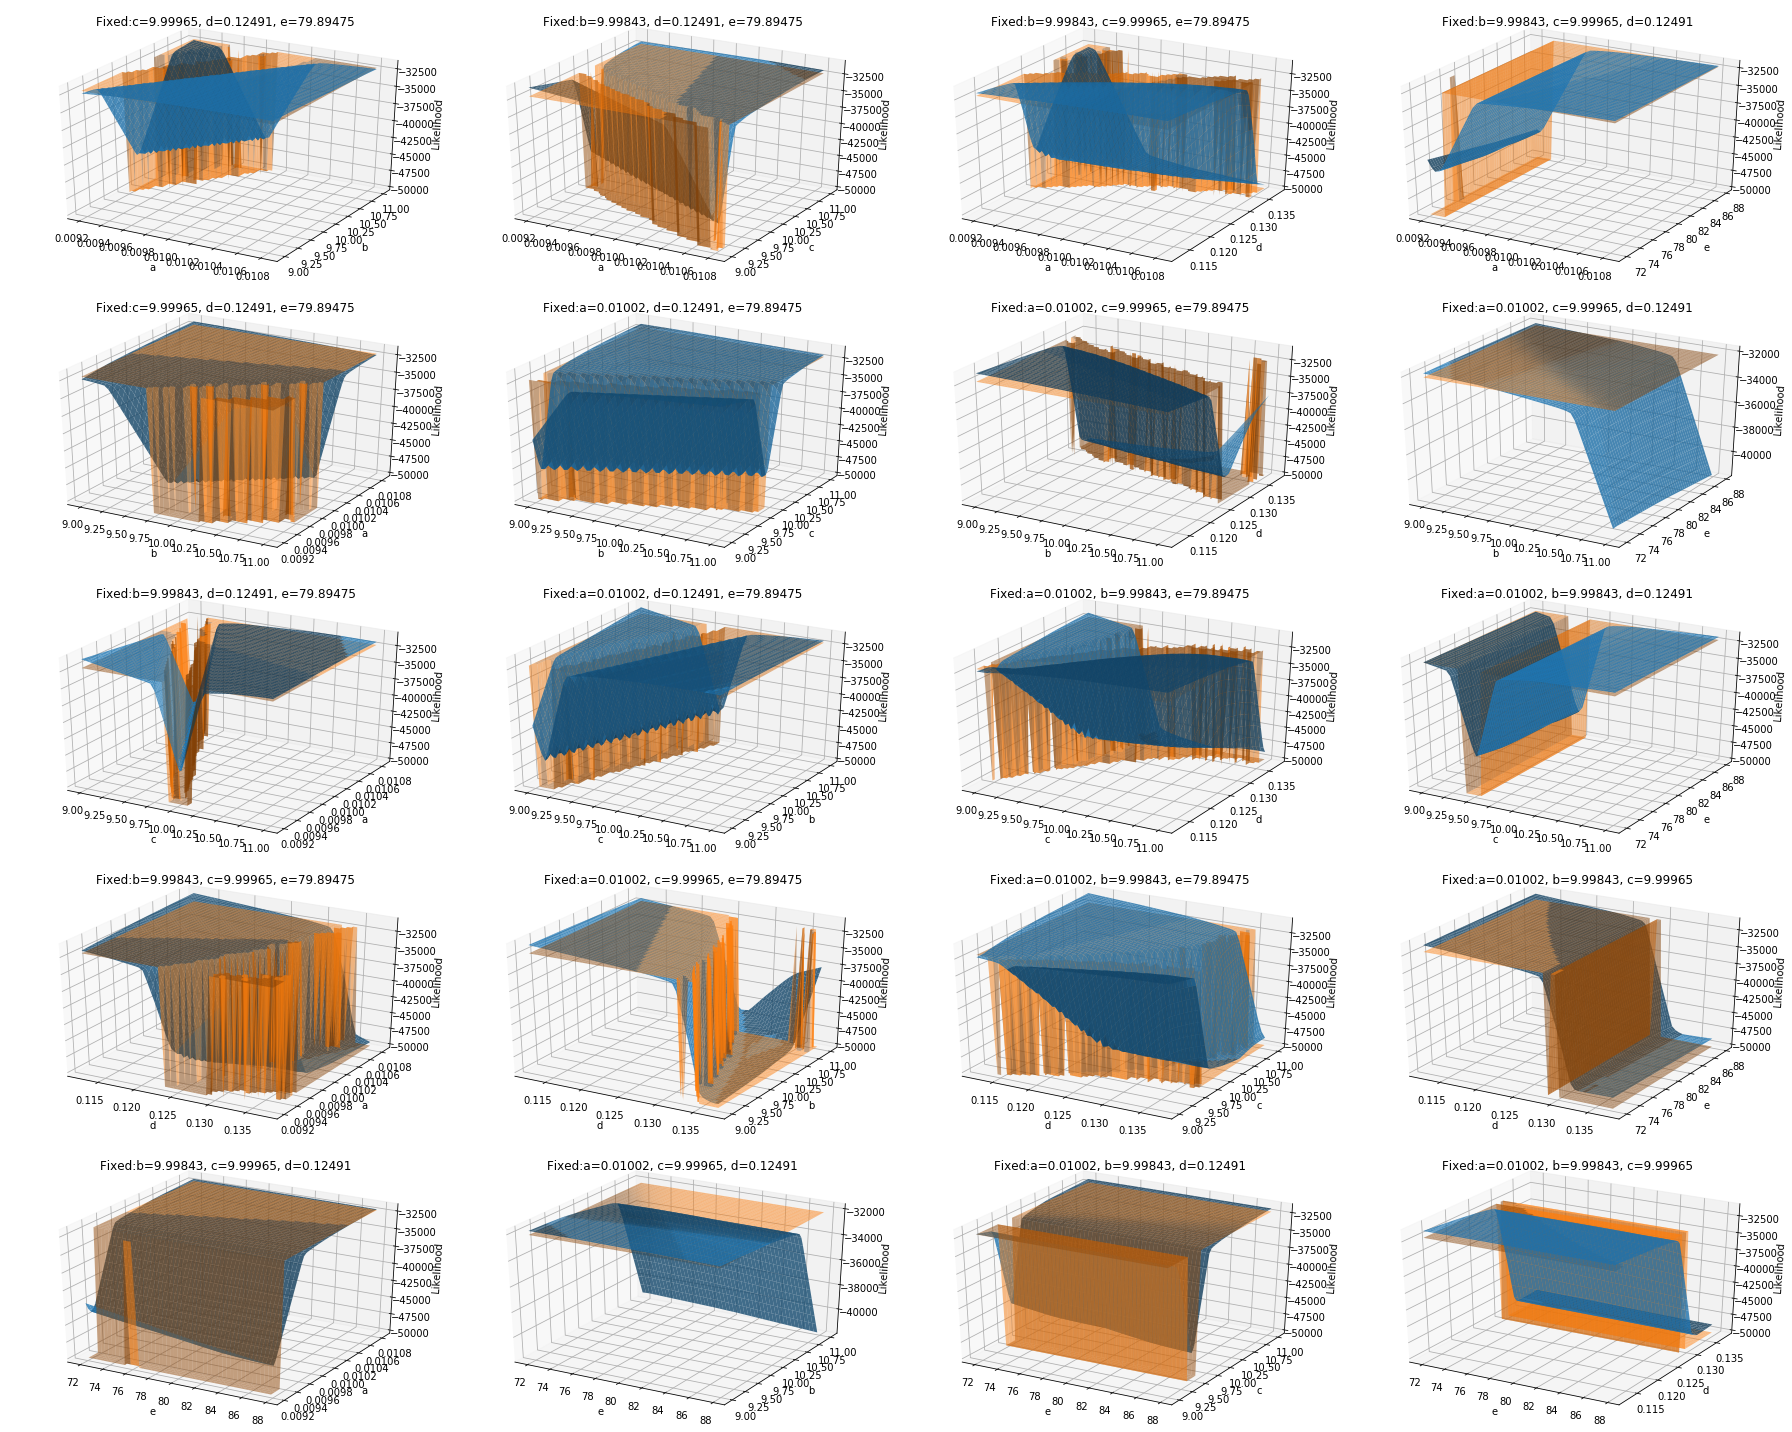

In [43]:
# plot surfaces
if n_parameters >= 3:
    fixed_parameters = emutils.fix_parameters(bounds)
    
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        shape = (n_parameters, n_parameters - 1),
        contour = False,
        index_to_param_name=index_to_param_name,
        additional_log_likelihoods = [log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

In [44]:
print(bounds.lower())
print(bounds.upper())

[9.21120698e-03 9.00000138e+00 9.00412153e+00 1.12537758e-01
 7.20000002e+01]
[1.08213179e-02 1.09968659e+01 1.09951808e+01 1.37284680e-01
 8.77895079e+01]


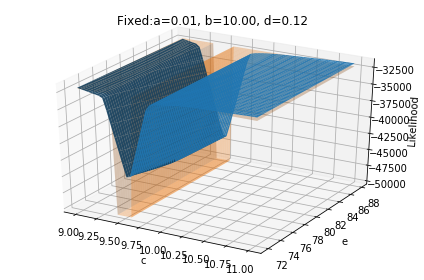

In [46]:
fig, ax = emuplt.plot_surface_fixed_param(
    emu,
    bounds,
    fixed = [(0, 0.01), (1, 10), (3, 0.125)],
    index_to_param_name=index_to_param_name,
    contour=False,
    precision=2,
    additional_log_likelihoods=[log_likelihood]
)

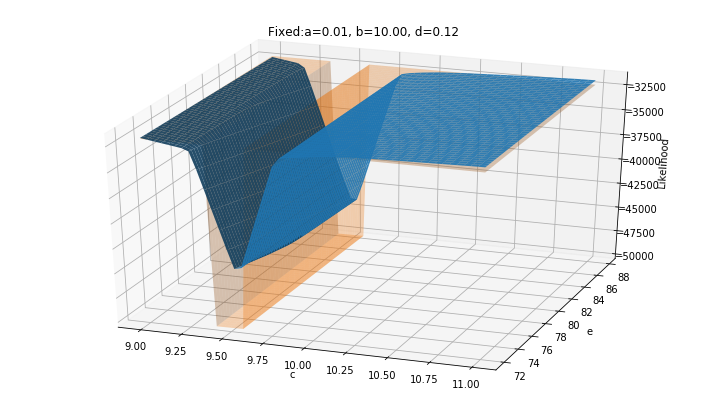

In [47]:
ax.view_init(30, 20 + 90 * 3)
fig.set_size_inches(10.5, 6)
fig